<a href="https://colab.research.google.com/github/iam-vsr/cnn_from_scratch/blob/main/cnn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📦 Importing Libraries**

Using NumPy for array operations, Matplotlib for visualization, and Keras to load the MNIST dataset.

In [3]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from matplotlib import pyplot as plt

# **📊 Loading and Preprocessing MNIST**

Loaded the MNIST dataset and reshaped images to `(1, 28, 28)` for channel-first format. Pixel values are normalized to [0, 1].


In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1,1,28,28)/255.0
X_test = X_test.reshape(-1,1,28,28)/255.0
(X_train.shape,X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


((60000, 1, 28, 28), (10000, 1, 28, 28))

**🎯 One-Hot Encoding Labels**

Converted integer labels into one-hot encoded vectors for multi-class classification (digits 0–9).

In [5]:
y_train_oh = np.zeros((y_train.shape[0], 10))
y_train_oh[np.arange(y_train.shape[0]), y_train] = 1
y_test_oh = np.zeros((y_test.shape[0], 10))
y_test_oh[np.arange(y_test.shape[0]), y_test] = 1
(y_train_oh.shape,y_test_oh.shape)

((60000, 10), (10000, 10))

# **Defining Functions**

### 🧱 **Convolution Layer**

Applies a 2D convolution operation using the given filters `W` and biases `b` over the input `X`.  
Supports optional `stride` and `padding`. Output shape is computed manually, and each region is convolved using nested loops.

In [6]:
def convolve(X, W, b, stride=1, padding=0):
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape

    h_out = (h_x - h_filter + 2 * padding) // stride + 1
    w_out = (w_x - w_filter + 2 * padding) // stride + 1
    out = np.zeros((n_x, n_filters, h_out, w_out))

    if padding > 0:
        X_padded = np.pad(X, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')
    else:
        X_padded = X

    for i in range(n_x):
        for f in range(n_filters):
            for h in range(h_out):
                for w in range(w_out):
                    h_start = h * stride
                    h_end = h_start + h_filter
                    w_start = w * stride
                    w_end = w_start + w_filter
                    region = X_padded[i, :, h_start:h_end, w_start:w_end]
                    out[i, f, h, w] = np.sum(region * W[f]) + b[f]
    return out

### **⚡ ReLU Activation**

Applies the ReLU (Rectified Linear Unit) activation function element-wise: replaces negative values with zero.

In [7]:
def relu(X):
  return np.maximum(0,X)

### 🧠 **Softmax Activation**

Converts raw output scores into probabilities by applying the softmax function across each sample’s output vector.

In [8]:
def softmax(X):
    exps = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

### **🔻 Max Pooling**

Performs 2×2 max pooling to downsample feature maps by taking the maximum value in each non-overlapping region.

In [9]:
def max_pool(X, size=2, stride=2):
    n, d, h, w = X.shape
    h_out = h // size
    w_out = w // size
    out = np.zeros((n, d, h_out, w_out))

    for i in range(n):
        for c in range(d):
            for h1 in range(h_out):
                for w1 in range(w_out):
                    h_start = h1 * stride
                    w_start = w1 * stride
                    h_end = h_start + size
                    w_end = w_start + size
                    out[i, c, h1, w1] = np.max(X[i, c, h_start:h_end, w_start:w_end])
    return out

### 🧾 **Flattening**

Reshapes the pooled feature maps into 2D arrays to feed into the fully connected (dense) layer.

In [10]:
def flatten(X):
  return X.reshape(X.shape[0],-1)

### 🔗 **Dense Layer**

Applies a fully connected layer: performs matrix multiplication with weights `W` and adds bias `b`.

In [11]:
def dense(X,W,b):
  return np.dot(X,W)+b

### ✅ **Predictions & Accuracy**

- `get_predictions`: Returns the predicted class by taking the index of the max probability.
- `accuracy`: Compares predictions with true labels and returns the overall classification accuracy.

In [12]:
def get_predictions(A2):
  return np.argmax(A2, axis=1)

def accuracy(predictions, y):
  return np.mean(predictions == np.argmax(y, axis=1))

### 🔄 **CNN Forward Pass Overview**

```text
Input (1×28×28)
      │
      ▼
[Conv2D: 4 filters, 3×3] ──► Z1 (4×26×26)
      │
      ▼
[ReLU Activation] ─────────► A1 (4×26×26)
      │
      ▼
[Max Pooling: 2×2] ────────► P1 (4×13×13)
      │
      ▼
[Flatten] ─────────────────► F (676,)
      │
      ▼
[Dense Layer → W2, b2] ────► Z2 (10,)
      │
      ▼
[Softmax] ─────────────────► A2 (10,) ← Predicted probabilities
```


In [13]:
def forward(W1, b1, W2, b2, X):
    Z1 = convolve(X, W1, b1)   # (N, 4, 26, 26)
    A1 = relu(Z1)              # (N, 4, 26, 26)
    P1 = max_pool(A1)          # (N, 4, 13, 13)
    F = flatten(P1)            # (N, 676)
    Z2 = dense(F, W2, b2)      # (N, 10)
    A2 = softmax(Z2)           # (N, 10)

    return Z1, A1, P1, F, Z2, A2

The Architecture is-

| Layer     | Output Shape      |
| --------- | ----------------- |
| Input     | `(N, 1, 28, 28)` |
| Conv      | `(N, 4, 26, 26)` |
| ReLU      | `(N, 4, 26, 26)` |
| MaxPool2D | `(N, 4, 13, 13)` |
| Flatten   | `(N, 676)`       |
| Dense     | `(N, 10)`        |
| Softmax   | `(N, 10)`        |


### **📉 Cross-Entropy Loss**

Calculates the average cross-entropy loss between predicted probabilities and one-hot encoded true labels.  
Uses `epsilon` to avoid log(0) for numerical stability.

In [17]:
def cross_entropy_loss(preds, labels):
    # preds: (batch_size, num_classes), probs after softmax
    # labels: one-hot, shape = (batch_size, num_classes)
    epsilon = 1e-12
    preds = np.clip(preds, epsilon, 1. - epsilon)
    return -np.mean(np.sum(labels * np.log(preds), axis=1))

Loss → ∂L/∂A2 → ∂L/∂Z2 → ∂L/∂W2, ∂L/∂b2 → ∂L/∂F → ∂L/∂P1 → ∂L/∂A1 → ∂L/∂Z1 → ∂L/∂W1, ∂L/∂b1


### **🔙 Gradient of Softmax + Cross-Entropy**

Computes the gradient of the loss with respect to the softmax output.  
Efficient due to the combined derivative of softmax and cross-entropy.

In [19]:
def grad_softmax_cross_entropy(preds, labels):
    return (preds - labels) / preds.shape[0]

### 🔁** Dense Layer Backward Pass**

Calculates gradients for:
- `dW`: weights,
- `db`: biases,
- `dA_prev`: activations from the previous layer  
using the chain rule and matrix multiplication.


In [20]:
def grad_dense(dZ, A_prev, W):
    dW = np.dot(A_prev.T, dZ)
    db = np.sum(dZ, axis=0)
    dA_prev = np.dot(dZ, W.T)
    return dA_prev, dW, db

### 🔄 **Gradient of Flatten**

Reshapes the gradient from the dense layer back to the original pooled feature map shape for further backpropagation.


In [21]:
def grad_flatten(dF, original_shape):
    return dF.reshape(original_shape)

### **🔁 Max Pooling Backward Pass**

Backpropagates gradients through the max pooling layer by assigning the gradient only to the position of the max value in each region.


In [22]:
def grad_maxpool(dout, A_prev, size=2, stride=2):
    N, C, H, W = A_prev.shape
    dA = np.zeros_like(A_prev)

    for n in range(N):
        for c in range(C):
            for h in range(0, H, size):
                for w in range(0, W, size):
                    h_end = h + size
                    w_end = w + size
                    region = A_prev[n, c, h:h_end, w:w_end]
                    max_pos = np.unravel_index(np.argmax(region), region.shape)
                    dA[n, c, h + max_pos[0], w + max_pos[1]] += dout[n, c, h//2, w//2]
    return dA

### 🔙 **ReLU Backward Pass**

Computes the gradient through the ReLU activation by passing gradients only where the original input `Z` was positive.


In [23]:
def grad_relu(dA, Z):
    return dA * (Z > 0)

### **🔁 Convolution Layer Backward Pass**

Backpropagates through the convolution layer by computing:
- `dW`: gradient w.r.t. filters  
- `db`: gradient w.r.t. biases  
- `dX`: gradient w.r.t. input (for previous layer)

Handles optional padding and uses nested loops for spatial gradient distribution.


In [24]:
def grad_conv(dZ, X, W, stride=1, padding=0):
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape
    dX = np.zeros_like(X)
    dW = np.zeros_like(W)
    db = np.zeros((n_filters,))

    if padding > 0:
        X_padded = np.pad(X, ((0,0), (0,0), (padding,padding), (padding,padding)), mode='constant')
        dX_padded = np.pad(dX, ((0,0), (0,0), (padding,padding), (padding,padding)), mode='constant')
    else:
        X_padded = X
        dX_padded = dX

    for i in range(n_x):
        for f in range(n_filters):
            for h in range(dZ.shape[2]):
                for w in range(dZ.shape[3]):
                    h_start = h * stride
                    h_end = h_start + h_filter
                    w_start = w * stride
                    w_end = w_start + w_filter

                    region = X_padded[i, :, h_start:h_end, w_start:w_end]
                    dW[f] += dZ[i, f, h, w] * region
                    db[f] += dZ[i, f, h, w]
                    dX_padded[i, :, h_start:h_end, w_start:w_end] += dZ[i, f, h, w] * W[f]

    if padding > 0:
        dX = dX_padded[:, :, padding:-padding, padding:-padding]
    else:
        dX = dX_padded
    return dX, dW, db

### 🔙 **Backward Pass**

Chains all layer-wise gradients in reverse order:
1. Output layer → Dense → Flatten  
2. Max Pooling → ReLU → Convolution

Returns gradients of all learnable parameters: `dW1`, `db1`, `dW2`, `db2`.


In [25]:
def backward(A1, W1, Z1, P1, F, A2, W2, Z2, X, y):
    dZ2 = grad_softmax_cross_entropy(A2, y)
    dF, dW2, db2 = grad_dense(dZ2, F, W2)
    dP1 = grad_flatten(dF, P1.shape)
    dA1 = grad_maxpool(dP1, A1)
    dZ1 = grad_relu(dA1, Z1)
    dX, dW1, db1 = grad_conv(dZ1, X, W1)
    return dW1, db1, dW2, db2

CNN Backward Pass Overview

```text
Loss (Cross Entropy)
        ▲
        │
[Softmax Output Layer]
        ▲
        │ dZ2
        │
[Dense Layer: W2, b2]
        ▲
        │ dF
        │
[Unflatten]
        ▲
        │ dP1
        │
[Max Pooling Backward]
        ▲
        │ dA1
        │
[ReLU Backward]
        ▲
        │ dZ1
        │
[Convolution Backward: W1, b1]
        ▲
        │ dX
        │
     Input X
```


### 🔧 **Weight Initialization**

Initializes learnable parameters:
- `W1`, `b1`: for the convolutional layer (4 filters, 3×3)
- `W2`, `b2`: for the dense layer (676 inputs → 10 outputs)

Uses He initialization for better convergence with ReLU.


In [26]:
def init_weights():
    W1 = np.random.randn(4, 1, 3, 3) * np.sqrt(2. / 9)
    b1 = np.zeros(4)  # 4 filters → 1 bias each

    W2 = np.random.randn(676, 10) * np.sqrt(2. / 676)
    b2 = np.zeros(10)  # 10 output classes

    return W1, b1, W2, b2

### **🛠️ Parameter Update**

Applies gradient descent to update all learnable parameters using their respective gradients and the learning rate.


In [27]:
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

# **🏋️ Training Loop**

Runs forward and backward passes for each epoch, updates parameters, and prints accuracy.  
This forms the core training routine for the CNN.


In [28]:
def train(X, y, epochs, lr):
    W1, b1, W2, b2 = init_weights()

    for epoch in range(epochs):
        Z1, A1, P1, F, Z2, A2 = forward(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward(A1, W1, Z1, P1, F, A2, W2, Z2, X, y)
        W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

        if epoch % 1 == 0:
            acc = accuracy(get_predictions(A2), y)
            print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc:.4f}")
    return W1, b1, W2, b2

In [29]:
W1, b1, W2, b2 = train(X_train[:1000], y_train_oh[:1000], 50, lr=0.1)

Epoch 1/50 - Accuracy: 0.1420
Epoch 2/50 - Accuracy: 0.2560
Epoch 3/50 - Accuracy: 0.3610
Epoch 4/50 - Accuracy: 0.4730
Epoch 5/50 - Accuracy: 0.5680
Epoch 6/50 - Accuracy: 0.6320
Epoch 7/50 - Accuracy: 0.6810
Epoch 8/50 - Accuracy: 0.7120
Epoch 9/50 - Accuracy: 0.7310
Epoch 10/50 - Accuracy: 0.7570
Epoch 11/50 - Accuracy: 0.7750
Epoch 12/50 - Accuracy: 0.7840
Epoch 13/50 - Accuracy: 0.7950
Epoch 14/50 - Accuracy: 0.8080
Epoch 15/50 - Accuracy: 0.8190
Epoch 16/50 - Accuracy: 0.8230
Epoch 17/50 - Accuracy: 0.8290
Epoch 18/50 - Accuracy: 0.8350
Epoch 19/50 - Accuracy: 0.8480
Epoch 20/50 - Accuracy: 0.8480
Epoch 21/50 - Accuracy: 0.8560
Epoch 22/50 - Accuracy: 0.8590
Epoch 23/50 - Accuracy: 0.8600
Epoch 24/50 - Accuracy: 0.8610
Epoch 25/50 - Accuracy: 0.8610
Epoch 26/50 - Accuracy: 0.8640
Epoch 27/50 - Accuracy: 0.8670
Epoch 28/50 - Accuracy: 0.8700
Epoch 29/50 - Accuracy: 0.8740
Epoch 30/50 - Accuracy: 0.8740
Epoch 31/50 - Accuracy: 0.8860
Epoch 32/50 - Accuracy: 0.8790
Epoch 33/50 - Acc

# **🔮 Making Predictions**

Performs a forward pass and returns the predicted class labels using `argmax` on the output probabilities.


In [30]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, _, _, A2 = forward(W1, b1, W2, b2, X)
    return get_predictions(A2)

### **🧪 Testing the Model**

Generates predictions on test data and evaluates performance using accuracy on the first 1000 test samples.

In [31]:
test_predictions = make_predictions(X_test[:1000], W1, b1, W2, b2)
print("Test accuracy: ",accuracy(test_predictions, y_test_oh[:1000]))

Test accuracy:  0.812


### **🖼️ Visualizing Predictions**

Displays a few test images along with predicted and true labels.  
Correct predictions are shown in green; incorrect ones in red.


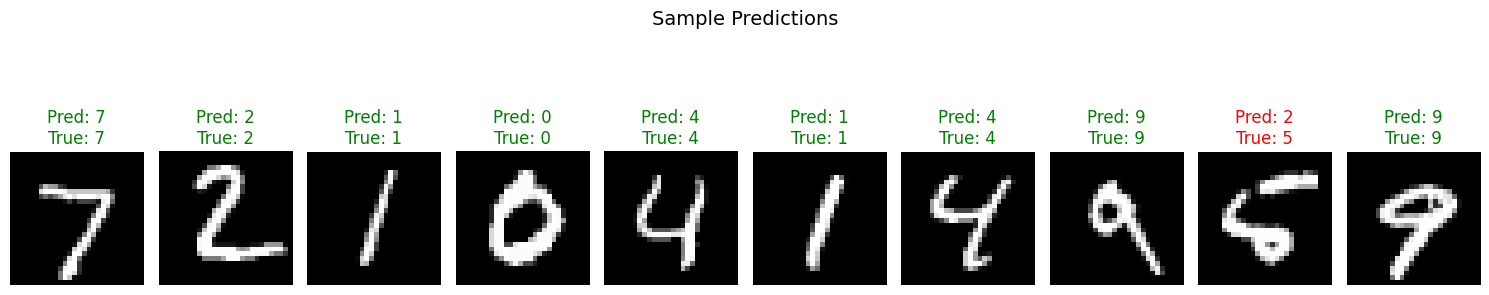

In [32]:
def show_sample_predictions(X, y_true, y_pred, count=10):
    plt.figure(figsize=(15, 4))
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        true_label = y_true[i] if isinstance(y_true[i], int) else np.argmax(y_true[i])
        pred_label = y_pred[i]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
                  color='green' if pred_label == true_label else 'red')
        plt.axis('off')
    plt.suptitle("Sample Predictions", fontsize=14)
    plt.tight_layout()
    plt.show()

preds = make_predictions(X_test[:10], W1, b1, W2, b2)
show_sample_predictions(X_test[:10], y_test_oh[:10], preds)

# ***✅ Conclusion***

We successfully built a simple Convolutional Neural Network (CNN) **from scratch using only NumPy** — no deep learning frameworks involved!

- 📈 **Final Test Accuracy**: **81.2%** on a subset of the MNIST test set  
- 🧠 Learned key components: convolution, activation, pooling, dense layers, and backpropagation  
- 🔁 Implemented full training and evaluation loops manually

#### ⚠️ Challenges & Limitations:
- Training was **very slow** due to Python-level loops in convolution and pooling — no GPU acceleration
- To keep computation reasonable, we used only:
  - **1000 samples for training**
  - **1000 samples for testing**
- Using the full 60,000+ samples would take hours without vectorization or GPU support

> 🧪 This project gave hands-on intuition about how CNNs actually work under the hood, building a strong foundation before using high-level frameworks like PyTorch or TensorFlow.
